# CS3244 Project Decision Tree Regressor

# Importing datasets and packages

We will begin with importing all relevant datasets and packages needed in order to create our model.

In [17]:
# Data Manipulation
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFECV, mutual_info_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    classification_report, 
    confusion_matrix,
    f1_score, 
    recall_score
)

import optuna
import matplotlib.pyplot as plt
import os


In [3]:
#load smote_train_data for training data and transformed_data for evaluation
smote_train_data_folder_path = '/Users/joanwong/Desktop/cs3244/finalised_datasets/smote_train_data'
transformed_data_folder_path = '/Users/joanwong/Desktop/cs3244/finalised_datasets/transformed_data'

smote_files = ['smote_fold_1.csv', 'smote_fold_2.csv', 'smote_fold_3.csv', 'smote_fold_4.csv', 'smote_fold_5.csv']
non_smote_files = ['fold_1.csv', 'fold_2.csv','fold_3.csv', 'fold_4.csv', 'fold_5.csv']


testing_data = pd.read_csv('/Users/joanwong/Desktop/cs3244/finalised_datasets/transformed_data/test_set.csv')
testing_data = testing_data.drop(columns = ['client_id', 'creation_date'])

# Feature Selection

##  Recursive Feature Elimination with Cross-Validation (RFECV)

Fold 1: Performing RFECV for feature selection...
Number of features selected by RFECV for Fold 1: 2
Selected features using RFECV: Index(['meter_number_count', 'reading_remark_8'], dtype='object')


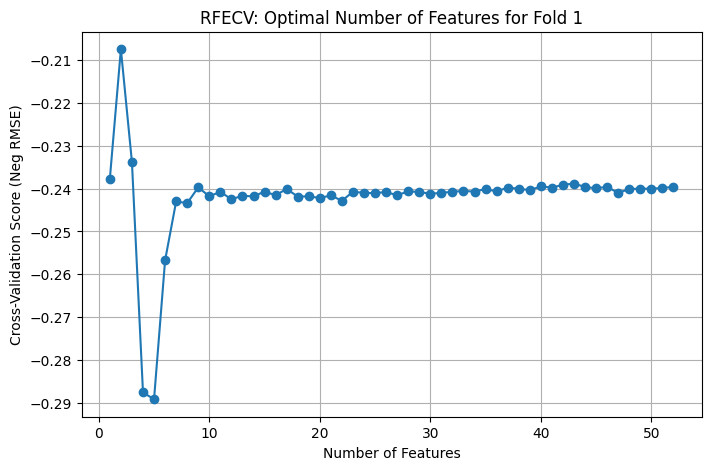

Fold 2: Performing RFECV for feature selection...
Number of features selected by RFECV for Fold 2: 2
Selected features using RFECV: Index(['meter_number_count', 'reading_remark_8'], dtype='object')


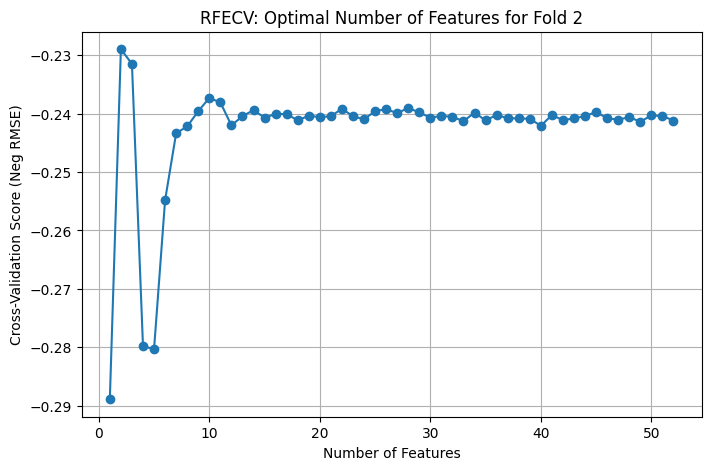

Fold 3: Performing RFECV for feature selection...
Number of features selected by RFECV for Fold 3: 2
Selected features using RFECV: Index(['months_number_max', 'meter_number_count'], dtype='object')


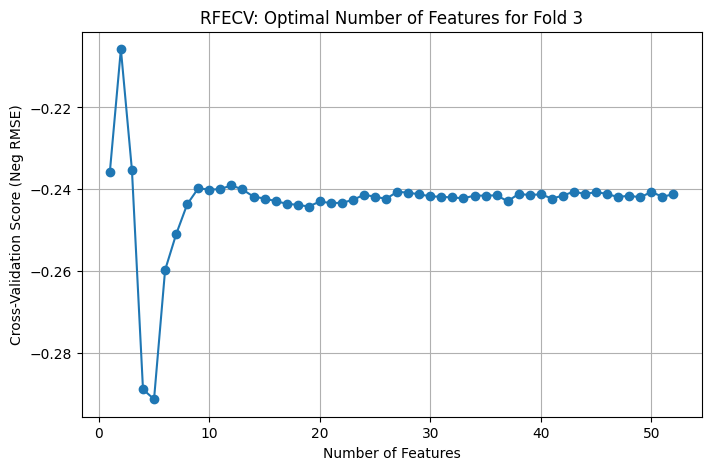

Fold 4: Performing RFECV for feature selection...
Number of features selected by RFECV for Fold 4: 2
Selected features using RFECV: Index(['meter_number_count', 'reading_remark_8'], dtype='object')


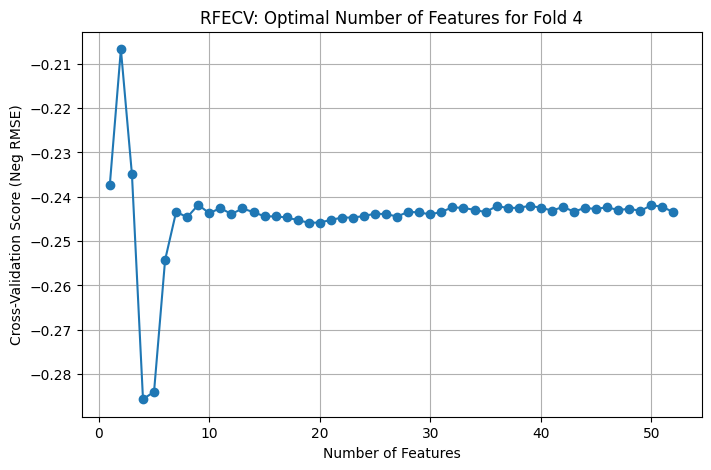

Fold 5: Performing RFECV for feature selection...
Number of features selected by RFECV for Fold 5: 2
Selected features using RFECV: Index(['meter_number_count', 'reading_remark_8'], dtype='object')


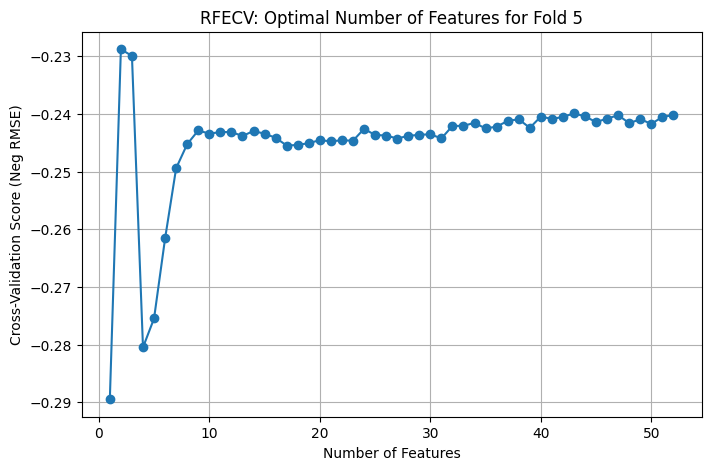

In [5]:
# Custom cross-validation using RFECV for regression
feature_counts_rfecv = []
selected_features_rfecv_all_folds = []
feature_rankings_rfecv = []

for i in range(len(smote_files)):
    # Define training and testing sets
    train_smote_files = [file for j, file in enumerate(smote_files) if j != i]  # All folds except the i-th for training
    test_non_smote_file = non_smote_files[i]  # The corresponding non-smoted fold for testing

    # Load training data
    train_dataframes = []
    for file in train_smote_files:
        file_path = os.path.join(smote_train_data_folder_path, file)
        df = pd.read_csv(file_path)
        train_dataframes.append(df)

    # Concatenate training data
    train_data = pd.concat(train_dataframes, ignore_index=True)

    # Load testing data
    test_file_path = os.path.join(smote_train_data_folder_path, test_non_smote_file)
    test_data = pd.read_csv(test_file_path)

    # Split features and target
    features = train_data.columns.drop('fraud_status')
    X_train = train_data[features]
    y_train = train_data['fraud_status']
    X_test = test_data[features]
    y_test = test_data['fraud_status']

    # Step 1: Feature Selection using RFECV
    print(f"Fold {i+1}: Performing RFECV for feature selection...")
    model = DecisionTreeRegressor(random_state=42)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    rfecv = RFECV(estimator=model, step=2, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    rfecv.fit(X_train, y_train)

    # Select the optimal features using RFECV
    selected_features_rfecv = X_train.columns[rfecv.support_]
    print(f"Number of features selected by RFECV for Fold {i+1}: {len(selected_features_rfecv)}")
    print("Selected features using RFECV:", selected_features_rfecv)
    feature_counts_rfecv.append(len(selected_features_rfecv))
    selected_features_rfecv_all_folds.append(selected_features_rfecv)
    feature_rankings_rfecv.append(pd.Series(rfecv.ranking_, index=X_train.columns))

    # Plot the number of features vs cross-validation score
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Cross-Validation Score (Neg RMSE)')
    plt.title(f'RFECV: Optimal Number of Features for Fold {i + 1}')
    plt.grid(True)
    plt.show()


### Selecting an Optimal Number of Features
Choosing the number of features based on when the graph of Number of Features Used vs Cross Validation (RSME) reaches a plateau.
Ranking of features is aggregated across the 5 folds.


Aggregated Feature Importance (RFECV):
meter_number_count       1.0
reading_remark_8         1.2
meter_code_count         2.2
district_63              4.0
district_69              4.0
                        ... 
reading_remark_7        48.8
meter_coefficient_3     49.0
meter_coefficient_50    49.2
meter_coefficient_2     49.2
region_199              50.2
Length: 102, dtype: float64


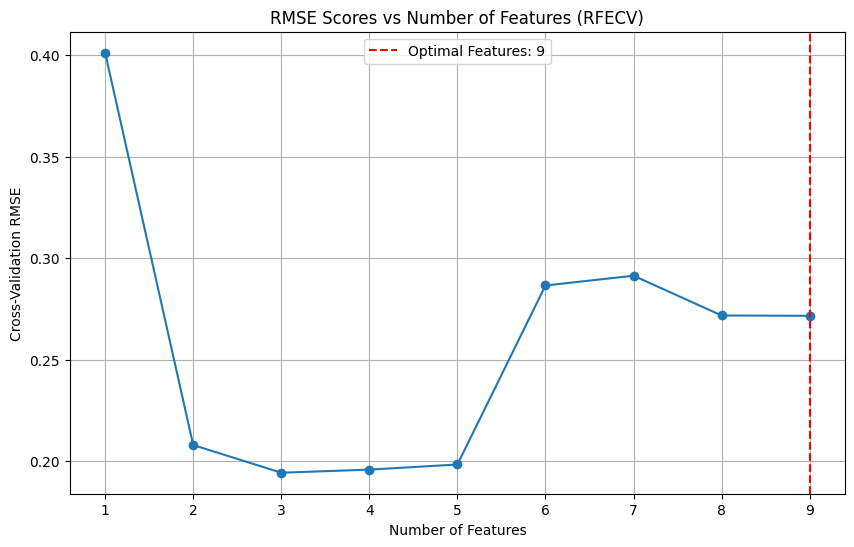

Optimal number of features where change is sufficiently close to 0 (RFECV): 9
Selected features based on optimal number (RFECV): ['meter_number_count', 'reading_remark_8', 'meter_code_count', 'district_63', 'district_69', 'old_index_median', 'region_101', 'district_62', 'months_number_max']


In [14]:
# Aggregated Feature Importance for RFECV
avg_rankings_rfecv = pd.concat(feature_rankings_rfecv, axis=1).mean(axis=1).sort_values()
print("\nAggregated Feature Importance (RFECV):")
print(avg_rankings_rfecv)

# Determine Optimal Features using Aggregated Feature Importance (RFECV)
rmse_scores_rfecv = []
threshold = 0.001  # Set a threshold for what counts as "sufficiently close to 0"
last_rmse_score = None
optimal_num_features_rfecv = None

# Loop through increasing numbers of features
for i in range(1, len(avg_rankings_rfecv) + 1):
    selected_features = avg_rankings_rfecv.head(i).index
    X_train_selected = X_train[selected_features]

    # Perform cross-validation with the selected features
    model = DecisionTreeRegressor(random_state=42)
    rmse = -cross_val_score(model, X_train_selected, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
    rmse_scores_rfecv.append(rmse)

    # Check if the difference is sufficiently small
    if last_rmse_score is not None:
        difference = abs(rmse - last_rmse_score)
        if difference <= threshold:
            optimal_num_features_rfecv = i
            break

    last_rmse_score = rmse

# Plot the RMSE scores vs number of features 
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rmse_scores_rfecv) + 1), rmse_scores_rfecv, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation RMSE')
plt.title('RMSE Scores vs Number of Features (RFECV)')
plt.grid()

# Mark the optimal number of features 
if optimal_num_features_rfecv is not None:
    plt.axvline(x=optimal_num_features_rfecv, color='r', linestyle='--', label=f'Optimal Features: {optimal_num_features_rfecv}')
plt.legend()
plt.show()

# Print the optimal number of features and the selected features
if optimal_num_features_rfecv is not None:
    print(f"Optimal number of features where change is sufficiently close to 0 (RFECV): {optimal_num_features_rfecv}")
    selected_features_rfecv_final = avg_rankings_rfecv.head(optimal_num_features_rfecv).index
    print(f"Selected features based on optimal number (RFECV): {list(selected_features_rfecv_final)}")
else:
    print("No plateau detected within the set threshold for RFECV.")

selected_features_rfecv = list(selected_features_rfecv_final)

## Mutual Information

Fold 1: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 1: 1
Selected features using Mutual Information: Index(['no_of_invoices'], dtype='object')


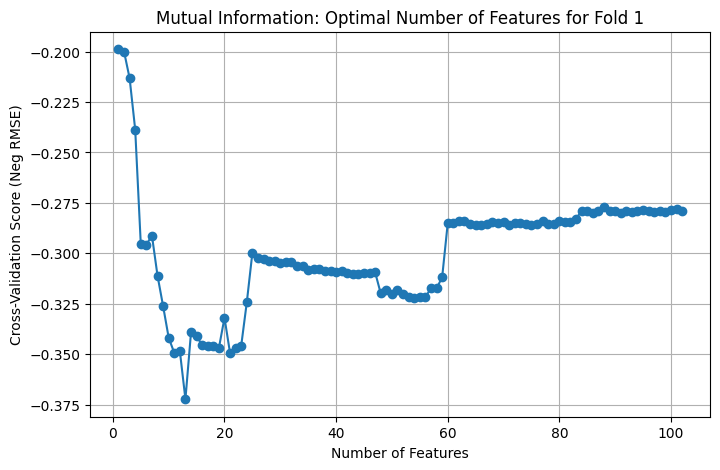

Fold 2: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 2: 1
Selected features using Mutual Information: Index(['is_index_discrepancy_False'], dtype='object')


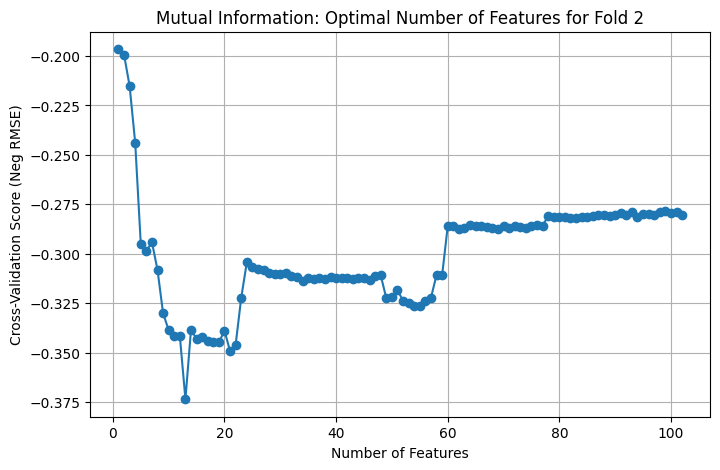

Fold 3: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 3: 1
Selected features using Mutual Information: Index(['is_index_discrepancy_False'], dtype='object')


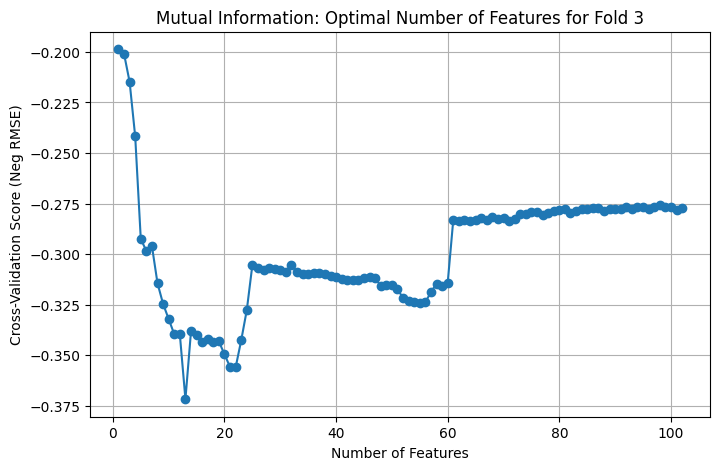

Fold 4: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 4: 1
Selected features using Mutual Information: Index(['no_of_invoices'], dtype='object')


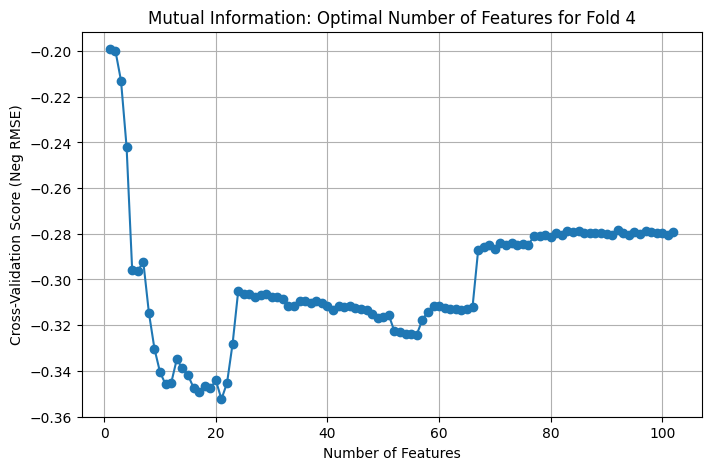

Fold 5: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 5: 1
Selected features using Mutual Information: Index(['is_index_discrepancy_False'], dtype='object')


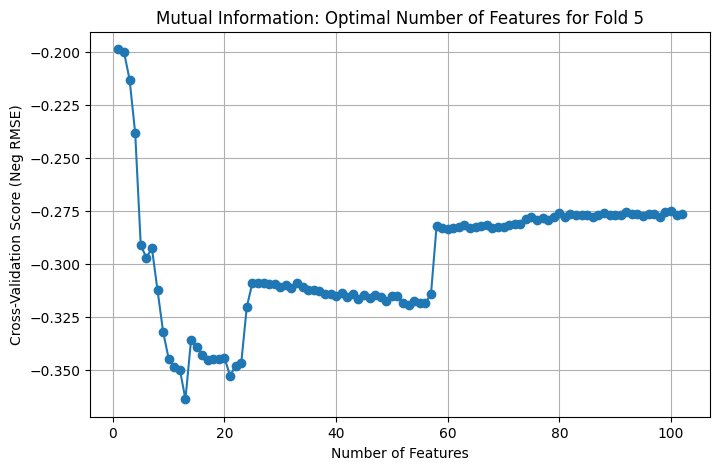

In [7]:
# Custom cross-validation using Mutual Information for regression
avg_mutual_info = []
feature_counts_mi = []
selected_features_mi_all_folds = []

for i in range(len(smote_files)):
    # Define training and testing sets
    train_smote_files = [file for j, file in enumerate(smote_files) if j != i]  # All folds except the i-th for training
    test_non_smote_file = non_smote_files[i]  # The corresponding non-smoted fold for testing

    # Load training data
    train_dataframes = []
    for file in train_smote_files:
        file_path = os.path.join(smote_train_data_folder_path, file)
        df = pd.read_csv(file_path)
        train_dataframes.append(df)

    # Concatenate training data
    train_data = pd.concat(train_dataframes, ignore_index=True)

    # Load testing data
    test_file_path = os.path.join(smote_train_data_folder_path, test_non_smote_file)
    test_data = pd.read_csv(test_file_path)

    # Split features and target
    features = train_data.columns.drop('fraud_status')
    X_train = train_data[features]
    y_train = train_data['fraud_status']
    X_test = test_data[features]
    y_test = test_data['fraud_status']

    # Feature Selection using Mutual Information
    print(f"Fold {i+1}: Performing Mutual Information for feature selection...")
    mutual_info = mutual_info_regression(X_train, y_train)
    mutual_info_series = pd.Series(mutual_info, index=X_train.columns).sort_values(ascending=False)
    avg_mutual_info.append(mutual_info_series)
    scores = []

    # Determine optimal number of features using cross-validation
    best_score = -np.inf
    optimal_k = 0
    for k in range(1, len(mutual_info_series) + 1):
        selected_features = mutual_info_series.head(k).index
        X_train_selected = X_train[selected_features]
        score = cross_val_score(DecisionTreeRegressor(random_state=42), X_train_selected, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
        scores.append(score)

        if score > best_score:
            best_score = score
            optimal_k = k

    print(f"Optimal number of features based on cross-validation for Fold {i + 1}: {optimal_k}")
    selected_features_mi_optimal = mutual_info_series.head(optimal_k).index
    print("Selected features using Mutual Information:", selected_features_mi_optimal)
    feature_counts_mi.append(len(selected_features_mi_optimal))
    selected_features_mi_all_folds.append(selected_features_mi_optimal)

    # Plot the cross-validation scores vs. number of features
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(mutual_info_series) + 1), scores, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Cross-Validation Score (Neg RMSE)')
    plt.title(f'Mutual Information: Optimal Number of Features for Fold {i + 1}')
    plt.grid(True)
    plt.show()


### Selecting an Optimal Number of Features
Choosing the number of features based on when the graph of Number of Features Used vs Cross Validation (F1 Score) reaches a plateau.
Ranking of features is aggregated across the 5 folds.


Aggregated Feature Importance (Mutual Information):
is_index_discrepancy_False     0.548725
no_of_invoices                 0.548322
meter_type_0                   0.535128
reading_remark_6               0.531339
time_since_last_invoice_max    0.529077
                                 ...   
meter_coefficient_50           0.000227
meter_status_2.0               0.000196
meter_coefficient_0            0.000188
meter_coefficient_3            0.000075
meter_status_3.0               0.000000
Length: 102, dtype: float64


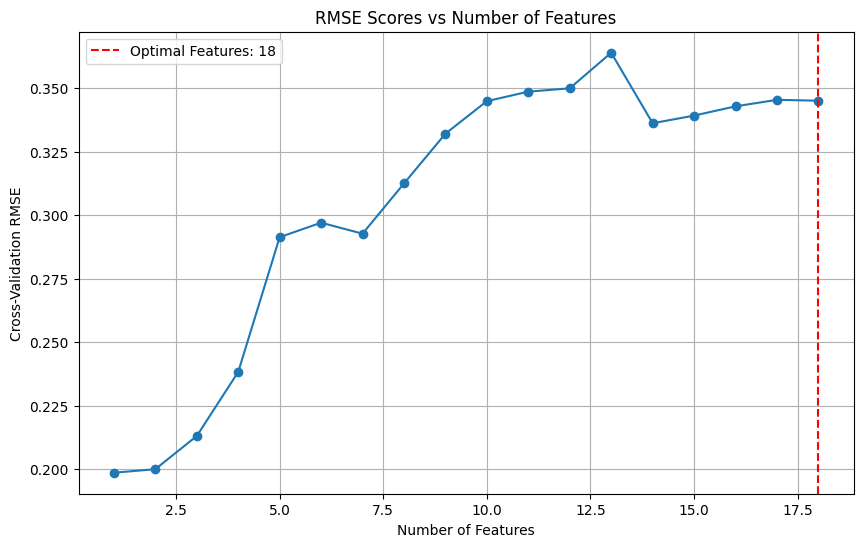

Optimal number of features where change is sufficiently close to 0: 18
Selected features based on optimal number: ['is_index_discrepancy_False', 'no_of_invoices', 'meter_type_0', 'reading_remark_6', 'time_since_last_invoice_max', 'reading_remark_9', 'reading_remark_8', 'time_since_last_invoice_min', 'time_since_last_invoice_median', 'consumption_level_1_max', 'total_consumption_max', 'diff_in_index_max', 'consumption_level_2_max', 'months_number_max', 'meter_type_1', 'consumption_level_1_min', 'consumption_level_2_sum', 'total_consumption_min']


In [8]:
# Aggregated Feature Importance for Mutual Information
avg_mutual_info_df = pd.concat(avg_mutual_info, axis=1).mean(axis=1).sort_values(ascending=False)
print("\nAggregated Feature Importance (Mutual Information):")
print(avg_mutual_info_df)

# Determine Optimal Features using Aggregated Feature Importance (Mutual Information)
rmse_scores = []
threshold = 0.001  # Set a threshold 
last_rmse_score = None
optimal_num_features = None

# Loop through increasing numbers of features
for i in range(1, len(avg_mutual_info_df) + 1):
    selected_features = avg_mutual_info_df.head(i).index
    X_train_selected = X_train[selected_features]

    # Perform cross-validation with the selected features
    model = DecisionTreeRegressor(random_state=42)
    rmse = -cross_val_score(model, X_train_selected, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
    rmse_scores.append(rmse)

    # Check if the difference is sufficiently small
    if last_rmse_score is not None:
        difference = abs(rmse - last_rmse_score)
        if difference <= threshold:
            optimal_num_features = i
            break

    last_rmse_score = rmse

# Plot the RMSE scores vs number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation RMSE')
plt.title('RMSE Scores vs Number of Features')
plt.grid()

# Mark the optimal number of features with a red dotted line
if optimal_num_features is not None:
    plt.axvline(x=optimal_num_features, color='r', linestyle='--', label=f'Optimal Features: {optimal_num_features}')
plt.legend()
plt.show()

# Print the optimal number of features and the selected features
if optimal_num_features is not None:
    print(f"Optimal number of features where change is sufficiently close to 0: {optimal_num_features}")
    selected_features_final = avg_mutual_info_df.head(optimal_num_features).index
    print(f"Selected features based on optimal number: {list(selected_features_final)}")
else:
    print("No plateau detected within the set threshold.")

selected_features_mi = list(selected_features_final)


# Methods Selection 

In [9]:
# Load the complete training and testing datasets
train_data = pd.concat([pd.read_csv(os.path.join(smote_train_data_folder_path, file)) for file in smote_files], ignore_index=True)
test_data = pd.read_csv(os.path.join(transformed_data_folder_path, 'test_set.csv'))

# Split features and target for training and testing
features = train_data.columns.drop('fraud_status')
X_train_full = train_data[features]
y_train_full = train_data['fraud_status']
X_test_full = test_data[features]
y_test_full = test_data['fraud_status']


# Create a sample with a stratified split to maintain class balance
sample_fraction = 0.1
X_sample, X_sample_test, y_sample, y_sample_test = train_test_split(X_train_full, y_train_full, test_size=(1 - sample_fraction), stratify=y_train_full, random_state=42)

# Choosing Between Feature Selection Methods

In [10]:
# Use Optuna to choose the best feature selection method (RFECV or Mutual Information)
def feature_selection_objective(trial):
    feature_method = trial.suggest_categorical('feature_method', ['RFECV', 'Mutual Information'])
    
    # Use the sampled dataset for training and testing
    if feature_method == 'RFECV':
        model = DecisionTreeRegressor(random_state=42)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        rfecv = RFECV(estimator=model, step=2, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
        rfecv.fit(X_sample, y_sample)
        selected_features = X_sample.columns[rfecv.support_]
    else:
        mutual_info = mutual_info_regression(X_sample, y_sample)
        mutual_info_series = pd.Series(mutual_info, index=X_sample.columns).sort_values(ascending=False)
        selected_features = mutual_info_series.head(15).index  # Choose top 15 features (can be adjusted)

    # Train and evaluate a model (DecisionTreeRegressor) using the selected features
    X_train_selected = X_sample[selected_features]
    model = DecisionTreeRegressor(random_state=42)
    rmse = -cross_val_score(model, X_train_selected, y_sample, cv=3, scoring='neg_root_mean_squared_error').mean()

    return rmse

# Run Optuna to find the best feature selection method
feature_study = optuna.create_study(direction='minimize')
feature_study.optimize(feature_selection_objective, n_trials=10)

best_feature_method = feature_study.best_trial.params['feature_method']
print("Best feature selection method:", best_feature_method)

[I 2024-11-30 12:33:07,493] A new study created in memory with name: no-name-ee83fbdc-e288-4d81-ae54-817fe4e33f66
[I 2024-11-30 12:33:18,279] Trial 0 finished with value: 0.3573561612560712 and parameters: {'feature_method': 'Mutual Information'}. Best is trial 0 with value: 0.3573561612560712.
[I 2024-11-30 12:33:30,398] Trial 1 finished with value: 0.3573561612560712 and parameters: {'feature_method': 'Mutual Information'}. Best is trial 0 with value: 0.3573561612560712.
[I 2024-11-30 12:33:40,485] Trial 2 finished with value: 0.36029082710929766 and parameters: {'feature_method': 'Mutual Information'}. Best is trial 0 with value: 0.3573561612560712.
[I 2024-11-30 12:34:38,463] Trial 3 finished with value: 0.22275280700717381 and parameters: {'feature_method': 'RFECV'}. Best is trial 3 with value: 0.22275280700717381.
[I 2024-11-30 12:35:41,894] Trial 4 finished with value: 0.22275280700717381 and parameters: {'feature_method': 'RFECV'}. Best is trial 3 with value: 0.2227528070071738

Best feature selection method: RFECV


# Hyperparameter Tuning & Choosing Best Ensemble Model with Optuna

In [11]:
# Use Optuna to choose the best ensemble model (Bagging/Random Forest/XGBoost/AdaBoost/LightGBM)
def model_selection_objective(trial):
    # Use the best feature selection method obtained from Step 7.1
    if best_feature_method == 'RFECV':
        model = DecisionTreeRegressor(random_state=42)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        rfecv = RFECV(estimator=model, step=2, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
        rfecv.fit(X_sample, y_sample)
        selected_features = X_sample.columns[rfecv.support_]
    else:
        mutual_info = mutual_info_regression(X_sample, y_sample)
        mutual_info_series = pd.Series(mutual_info, index=X_sample.columns).sort_values(ascending=False)
        selected_features = mutual_info_series.head(15).index
    
    X_train_selected = X_sample[selected_features]
    y_train = y_sample
    
    # Choose the model type and hyperparameters
    model_name = trial.suggest_categorical('model_name', ['Bagging', 'RandomForest', 'AdaBoost', 'XGBoost', 'LightGBM'])
    
    if model_name == 'Bagging':
        n_estimators = trial.suggest_int('n_estimators', 10, 100, step=10)
        max_samples = trial.suggest_float('max_samples', 0.5, 1.0, step=0.1)
        model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=n_estimators, max_samples=max_samples, random_state=42)
    elif model_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        max_depth = trial.suggest_int('max_depth', 10, 30, step=10)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif model_name == 'AdaBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
        model = AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 9, step=3)
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
        num_leaves = trial.suggest_int('num_leaves', 31, 100, step=10)
        model = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, random_state=42)

    # Train and evaluate the model
    rmse = -cross_val_score(model, X_train_selected, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
    return rmse

# Run Optuna to find the best ensemble model
model_study = optuna.create_study(direction='minimize')
model_study.optimize(model_selection_objective, n_trials=20)

[I 2024-11-30 12:37:52,432] A new study created in memory with name: no-name-afe03fe3-8290-432c-a6dc-cb607c015a75
[I 2024-11-30 12:39:04,152] Trial 0 finished with value: 0.24285315076889666 and parameters: {'model_name': 'RandomForest', 'n_estimators': 50, 'max_depth': 20}. Best is trial 0 with value: 0.24285315076889666.
[I 2024-11-30 12:40:18,099] Trial 1 finished with value: 0.3169352026114222 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 50, 'learning_rate': 0.6869598553966118}. Best is trial 0 with value: 0.24285315076889666.
[I 2024-11-30 12:41:15,538] Trial 2 finished with value: 0.40804649141642874 and parameters: {'model_name': 'XGBoost', 'n_estimators': 100, 'learning_rate': 0.010874256146909343, 'max_depth': 3}. Best is trial 0 with value: 0.24285315076889666.
[I 2024-11-30 12:42:12,400] Trial 3 finished with value: 0.2604437178518279 and parameters: {'model_name': 'XGBoost', 'n_estimators': 50, 'learning_rate': 0.17201708672988572, 'max_depth': 6}. Best is tri

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13652, number of used features: 2
[LightGBM] [Info] Start training from score 0.503662
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13652, number of used features: 2
[LightGBM] [Info] Start training from score 0.502857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5

[I 2024-11-30 12:50:47,340] Trial 12 finished with value: 0.3431939848734891 and parameters: {'model_name': 'LightGBM', 'n_estimators': 100, 'learning_rate': 0.0102200762055156, 'num_leaves': 31}. Best is trial 10 with value: 0.22425873862482404.
[I 2024-11-30 12:51:42,880] Trial 13 finished with value: 0.22425873862482404 and parameters: {'model_name': 'Bagging', 'n_estimators': 10, 'max_samples': 1.0}. Best is trial 10 with value: 0.22425873862482404.
[I 2024-11-30 12:52:40,872] Trial 14 finished with value: 0.22425873862482404 and parameters: {'model_name': 'Bagging', 'n_estimators': 10, 'max_samples': 1.0}. Best is trial 10 with value: 0.22425873862482404.
[I 2024-11-30 12:53:39,155] Trial 15 finished with value: 0.2249500663355137 and parameters: {'model_name': 'Bagging', 'n_estimators': 20, 'max_samples': 0.8}. Best is trial 10 with value: 0.22425873862482404.
/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packag

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13652, number of used features: 2
[LightGBM] [Info] Start training from score 0.503662
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13652, number of used features: 2
[LightGBM] [Info] Start training from score 0.502857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13652, number of used features: 2
[LightGBM] [Info] Start training 

[I 2024-11-30 12:54:39,493] Trial 16 finished with value: 0.22356603305452602 and parameters: {'model_name': 'LightGBM', 'n_estimators': 100, 'learning_rate': 0.1165808148130228, 'num_leaves': 91}. Best is trial 16 with value: 0.22356603305452602.
/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13652, number of used features: 2
[LightGBM] [Info] Start training from score 0.503662
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13652, number of used features: 2
[LightGBM] [Info] Start training from score 0.502857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 136

[I 2024-11-30 12:55:41,853] Trial 17 finished with value: 0.22304542838793415 and parameters: {'model_name': 'LightGBM', 'n_estimators': 150, 'learning_rate': 0.12394758010686371, 'num_leaves': 91}. Best is trial 17 with value: 0.22304542838793415.
/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13652, number of used features: 2
[LightGBM] [Info] Start training from score 0.503662
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13652, number of used features: 2
[LightGBM] [Info] Start training from score 0.502857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 136

[I 2024-11-30 12:56:43,995] Trial 18 finished with value: 0.22309506417869154 and parameters: {'model_name': 'LightGBM', 'n_estimators': 150, 'learning_rate': 0.11614430324089028, 'num_leaves': 91}. Best is trial 17 with value: 0.22304542838793415.
/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13652, number of used features: 2
[LightGBM] [Info] Start training from score 0.503662
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13652, number of used features: 2
[LightGBM] [Info] Start training from score 0.502857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 136

[I 2024-11-30 12:57:48,664] Trial 19 finished with value: 0.22292090911693893 and parameters: {'model_name': 'LightGBM', 'n_estimators': 150, 'learning_rate': 0.1471665382467452, 'num_leaves': 91}. Best is trial 19 with value: 0.22292090911693893.


# Fitting the Model with Best Parameters found & Evaluation Metrics

In [21]:
best_params = model_study.best_trial.params
print("Best parameters found:", best_params)

# Use the best parameters to initialize and train the model
model_name = best_params['model_name']

if model_name == 'Bagging':
    best_model = BaggingRegressor(
        estimator=DecisionTreeRegressor(),
        n_estimators=best_params['n_estimators'],
        max_samples=best_params['max_samples'],
        random_state=42
    )
elif model_name == 'RandomForest':
    best_model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        random_state=42
    )
elif model_name == 'AdaBoost':
    best_model = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(),
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        random_state=42
    )
elif model_name == 'XGBoost':
    best_model = XGBRegressor(
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        random_state=42,
        eval_metric='rmse'
    )
elif model_name == 'LightGBM':
    best_model = LGBMRegressor(
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        num_leaves=best_params['num_leaves'],
        random_state=42
    )


# Determine the features to use based on the best feature selection method
if best_feature_method == 'RFECV':
    selected_features = selected_features_rfecv
else:
    selected_features = selected_features_mi 

    
# Train the model
best_model.fit(X_train_full[selected_features], y_train_full)

# Predict on the full test dataset using the selected features
y_pred = best_model.predict(X_test_full[selected_features])

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_full, y_pred))
mae = mean_absolute_error(y_test_full, y_pred)
r2 = r2_score(y_test_full, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Best parameters found: {'model_name': 'LightGBM', 'n_estimators': 150, 'learning_rate': 0.1471665382467452, 'num_leaves': 91}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 204784, number of used features: 9
[LightGBM] [Info] Start training from score 0.500000
Root Mean Squared Error (RMSE): 0.2224
Mean Absolute Error (MAE): 0.1048
R-squared (R2): 0.0905


## Determining the Best Threshold Value to Use

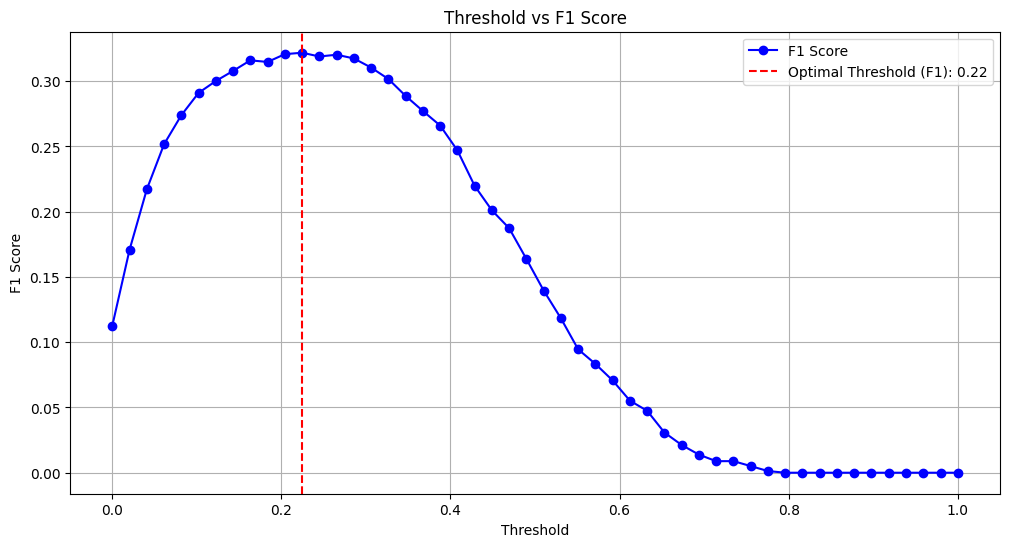

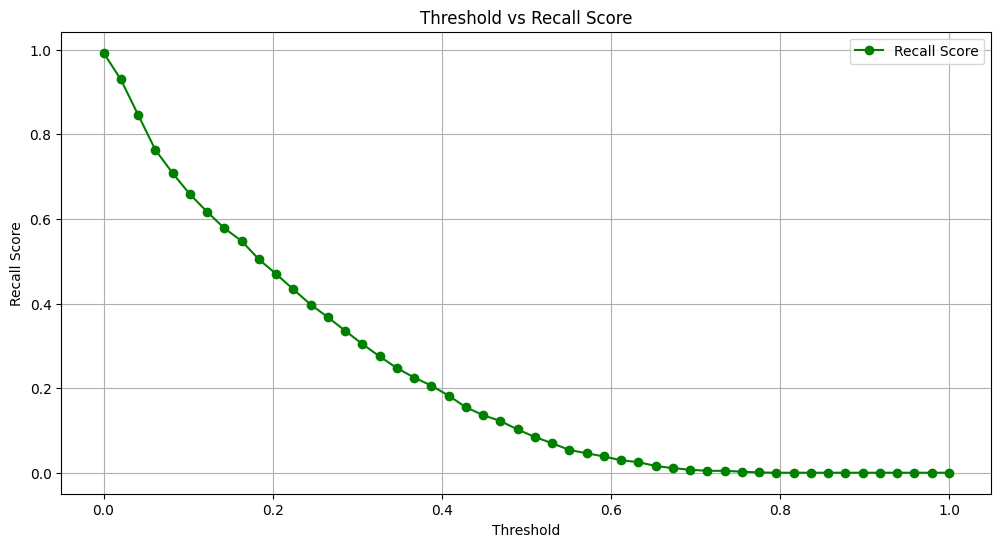

The optimal threshold for the highest F1 Score (0.3218) is: 0.22


In [22]:
# Define the range of threshold values to evaluate
thresholds = np.linspace(0.0, 1.0, num=50)  # 50 threshold values between 0 and 1

f1_scores = []
recall_scores = []

# Loop through each threshold and calculate F1 and recall
for threshold in thresholds:
    y_pred_class = (y_pred > threshold).astype(int)
    f1 = f1_score(y_test_full, y_pred_class, zero_division=1)
    recall = recall_score(y_test_full, y_pred_class, zero_division=1)
    
    f1_scores.append(f1)
    recall_scores.append(recall)

# Find the highest F1 score and the corresponding threshold
max_f1_score = max(f1_scores)
optimal_threshold_f1 = thresholds[f1_scores.index(max_f1_score)]

# Plotting Threshold vs F1 Score
plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score', color='b')
plt.axvline(x=optimal_threshold_f1, color='r', linestyle='--', label=f'Optimal Threshold (F1): {optimal_threshold_f1:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Threshold vs Recall Score
plt.figure(figsize=(12, 6))
plt.plot(thresholds, recall_scores, marker='o', label='Recall Score', color='g')
plt.xlabel('Threshold')
plt.ylabel('Recall Score')
plt.title('Threshold vs Recall Score')
plt.grid(True)
plt.legend()
plt.show()

# Print the optimal threshold value for the highest F1 score
print(f"The optimal threshold for the highest F1 Score ({max_f1_score:.4f}) is: {optimal_threshold_f1:.2f}")

In [23]:
# Evaluating as a classification report for threshold-based results using classification metrics
# Regression outputs to binary classification
threshold = 0.22
y_pred_class = (y_pred > threshold).astype(int)

print("\nClassification Report (using threshold for binary output):")
print(classification_report(y_test_full, y_pred_class))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_full, y_pred_class))


Classification Report (using threshold for binary output):
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     25535
         1.0       0.25      0.44      0.32      1564

    accuracy                           0.89     27099
   macro avg       0.61      0.68      0.63     27099
weighted avg       0.92      0.89      0.91     27099


Confusion Matrix:
[[23482  2053]
 [  870   694]]
